In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import seaborn as sns
from PIL import Image
import glob


In [2]:
maze_size = 7

In [3]:
df_map_raw = pd.read_csv('./map.csv', header=None)
df_map = df_map_raw.copy()

In [4]:
df_map.replace(-1, 0, inplace=True)
df_map.replace(99, 0, inplace=True)
df_map

,0,1,2,3,4,5,6
0,1,1,1,1,1,1,1
1,1,0,1,0,0,0,1
2,1,0,1,0,1,1,1
3,1,0,0,0,0,0,1
4,1,0,1,0,1,1,1
5,1,0,1,0,0,0,1
6,1,1,1,1,1,1,1


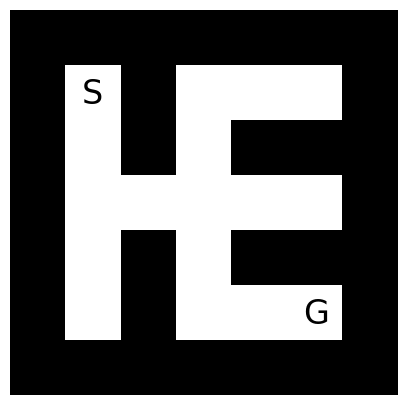

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(df_map, ax=ax, cmap='gray_r', cbar=False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.text(1.3,1.7,'S', fontsize=24)
ax.text(5.3,5.7,'G', fontsize=24)
plt.savefig("map.pdf", bbox_inches='tight', pad_inches=0)
plt.show()


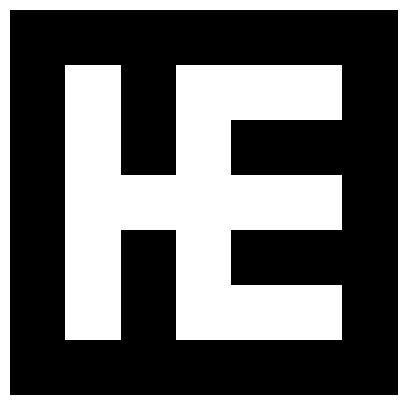

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(df_map, ax=ax, cmap='gray_r', cbar=False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig("map.png", bbox_inches='tight', pad_inches=0)
plt.show()

In [7]:
pos_dic = {
    1:(1,1),
    2:(1,3),
    3:(1,5),
    4:(3,1),
    5:(3,3),
    6:(3,5),
    7:(5,1),
    8:(5,3),
    9:(5,5)
}
max_path_width = 2
min_path_width = 0.5

In [8]:
def get_act_list(path, no):
    df_act = pd.read_csv(path)
    
    act_text = df_act['path'][no]
    splited_act_text_list = act_text.split(' ')
    act_list = [t.replace('True', '').replace('False', '').split(':') for t in splited_act_text_list]
    if act_list[-1][0] == '':
        del act_list[-1]
    return act_list

In [9]:
def get_counted_map(path, no):

    targetd_act_list = get_act_list(path, no)
    
    counted_locations = [0] * len(pos_dic)
    for one_round_list in targetd_act_list:
        for l in one_round_list:
            counted_locations[int(l)-1] += 1
            counted_locations
        
    counted_map = np.zeros((maze_size, maze_size))
    for i, num in enumerate(counted_locations):
        y, x = pos_dic[i+1]
        counted_map[maze_size-1-y,x] = num 
    return counted_map

In [10]:
def get_path_frequency_ratio(path, no):
    act_list = get_act_list(path, no)
    path_pares = {}
    for one_round_list in act_list:
        for i in range(0, len(one_round_list)-1):
            current_point = int(one_round_list[i])
            next_point = int(one_round_list[i+1])
            if current_point == next_point:
                continue
            if not (current_point, next_point) in path_pares and not (next_point, current_point) in path_pares:
                path_pares[(current_point, next_point)] = 1
            else:
                if (current_point, next_point) in path_pares:
                    path_pares[(current_point, next_point)] += 1
                else:
                    path_pares[(next_point, current_point)] += 1
    max_num = max(path_pares.values())   
    return {k : path_pares[k] / max_num for k in path_pares}

In [11]:
def draw_trajectory_map(ax, im, x, y, v, maze_size, path_ratio_dic, addjust_value):
    ax.imshow(im, extent=(-addjust_value, maze_size -1 + addjust_value, -addjust_value, maze_size - 1 + addjust_value))
    ax.set_xlim([-addjust_value,maze_size - 1+addjust_value])
    ax.set_ylim([-addjust_value,maze_size - 1+addjust_value])
    ax.scatter(x=x, y=y, c=v, alpha=1, s=50 ,marker='o', cmap='OrRd') 
    ax.grid(False)

    for k, v in path_ratio_dic.items():
        p0 = pos_dic[k[0]]
        p1 = pos_dic[k[1]]
        linewdith = (max_path_width - min_path_width) * v + min_path_width
        ax.plot([p0[1], p1[1]], [maze_size -1 - p0[0], maze_size -1 - p1[0]], color='blue', linewidth=linewdith)
    ax.get_xaxis().set_visible(False)

In [12]:
def read_action_data(path, no):
    x = []
    y = []
    v = []
    counted_map = get_counted_map(path, no)
    path_ratio_dic = get_path_frequency_ratio(path, no)
    for i in range(0,maze_size):
        for j in range(0,maze_size):
            if counted_map[i,j] > 0:
                y.append(i)
                x.append(j)
                v.append(counted_map[i,j])
    return x, y, v, path_ratio_dic

In [13]:
def draw_conner_heatmap_with_path(axes, path_l, no_ll, low_title, high_title):
    addjust_value = 0.5
    with Image.open('./map.png') as im:
        for row, no_l in enumerate(no_ll):
            for model_no, (path, no) in enumerate(zip(path_l, no_l)):
                x, y, v, path_ratio_dic = read_action_data(path, no)
                draw_trajectory_map(axes[row][model_no], im, x, y, v, maze_size, path_ratio_dic, addjust_value)
    axes[0][0].set_ylabel(low_title, fontsize = 11)
    axes[0][0].set_yticklabels([])
    axes[1][0].set_ylabel(high_title, fontsize = 11)
    axes[1][0].set_yticklabels([])
    axes[0][1].get_yaxis().set_visible(False)
    axes[0][2].get_yaxis().set_visible(False)
    axes[1][1].get_yaxis().set_visible(False)
    axes[1][2].get_yaxis().set_visible(False)

    # fig.tight_layout(pad=10)
    # plt.tight_layout()
    plt.savefig("conner_point_heatmap_with_path.pdf", bbox_inches='tight', pad_inches=0)

In [14]:
def draw_model_trajectory_map(axes, model_name, path_list, no_list):
    addjust_value = 0.5
    with Image.open('./map.png') as im:
        for i, (path, no) in enumerate(zip(path_list, no_list)):
            x, y, v, path_ratio_dic = read_action_data(path, no)
            draw_trajectory_map(axes[i], im, x, y, v, maze_size, path_ratio_dic, addjust_value)
            
    # axes[0][0].set_ylabel(low_title, fontsize = 11)
    # axes[0][0].set_yticklabels([])
    # axes[1][0].set_ylabel(high_title, fontsize = 11)
    # axes[1][0].set_yticklabels([])
    for ax in axes:   
        ax.get_yaxis().set_visible(False)
        ax.set_yticklabels([])

    axes[0].get_yaxis().set_visible(True)
    axes[0].set_ylabel(model_name, fontsize = 11)

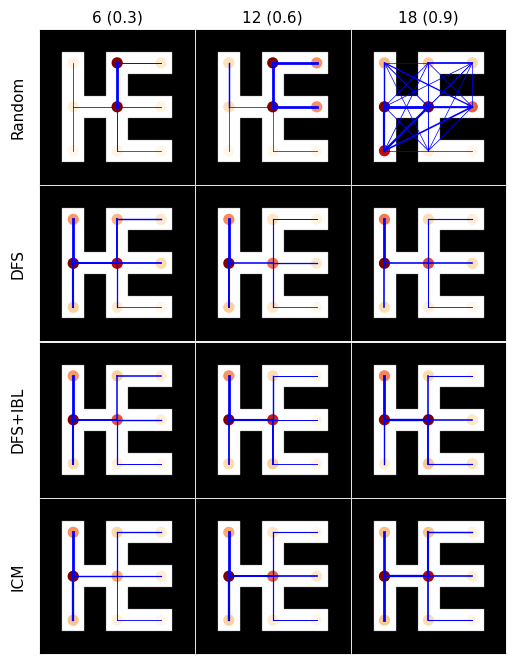

In [15]:
fig, axes = plt.subplots(4, 3, figsize=(6, 9))
plt.subplots_adjust(hspace = -0.3,wspace=0.012)
plt.grid(False)
path_r = ['./action/r_3600_7_7_10_6_1_1_180.csv', './action/r_3600_7_7_10_12_1_1_180.csv', './action/r_3600_7_7_10_18_1_1_180.csv']
path_b = ['./action/b_3600_7_7_10_6_1_1_180.csv', './action/b_3600_7_7_10_12_1_1_180.csv', './action/b_3600_7_7_10_18_1_1_180.csv']
path_i = ['./action/i_3600_7_7_10_6_1_1_180.csv', './action/i_3600_7_7_10_12_1_1_180.csv', './action/i_3600_7_7_10_18_1_1_180.csv']
path_icm = ['./action/icm_06_7_7.csv', './action/icm_12_7_7.csv', './action/icm_18_7_7.csv']

no_r = [0, 1, 8]
no_b = [8, 1, 8]
no_i = [9, 3, 8]
no_icm = [9, 8, 5]

axes[0][0].set_title('6 (0.3)', fontsize = 11)
axes[0][1].set_title('12 (0.6)', fontsize = 11)
axes[0][2].set_title('18 (0.9)', fontsize = 11)

axes[0][0].tick_params(bottom=False, left=False, right=False, top=False)
axes[1][0].tick_params(bottom=False, left=False, right=False, top=False)
axes[2][0].tick_params(bottom=False, left=False, right=False, top=False)
axes[3][0].tick_params(bottom=False, left=False, right=False, top=False)

draw_model_trajectory_map(axes[0],'Random', path_r, no_r)
draw_model_trajectory_map(axes[1],'DFS', path_b, no_b)
draw_model_trajectory_map(axes[2],'DFS+IBL', path_i, no_i)
draw_model_trajectory_map(axes[3],'ICM', path_icm, no_icm)
plt.savefig("trajectory_map_l.pdf", bbox_inches='tight', pad_inches=0)

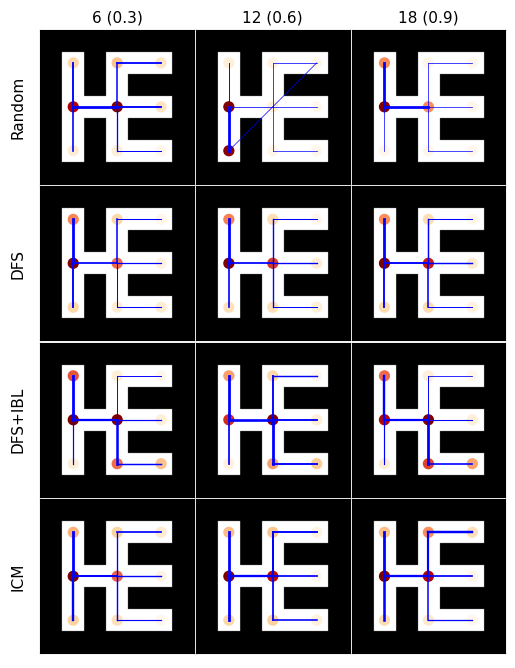

In [16]:
fig, axes = plt.subplots(4, 3, figsize=(6, 9))
plt.subplots_adjust(hspace = -0.3,wspace=0.012)
plt.grid(False)
path_r = ['./action/r_3600_7_7_10_6_1_1_180.csv', './action/r_3600_7_7_10_12_1_1_180.csv', './action/r_3600_7_7_10_18_1_1_180.csv']
path_b = ['./action/b_3600_7_7_10_6_1_1_180.csv', './action/b_3600_7_7_10_12_1_1_180.csv', './action/b_3600_7_7_10_18_1_1_180.csv']
path_i = ['./action/i_3600_7_7_10_6_1_1_180.csv', './action/i_3600_7_7_10_12_1_1_180.csv', './action/i_3600_7_7_10_18_1_1_180.csv']
path_icm = ['./action/icm_06_7_7.csv', './action/icm_12_7_7.csv', './action/icm_18_7_7.csv']

no_r = [3, 6, 2]
no_b = [7, 0, 9]
no_i = [1, 1, 3]
no_icm = [4, 7, 8]

axes[0][0].set_title('6 (0.3)', fontsize = 11)
axes[0][1].set_title('12 (0.6)', fontsize = 11)
axes[0][2].set_title('18 (0.9)', fontsize = 11)

axes[0][0].tick_params(bottom=False, left=False, right=False, top=False)
axes[1][0].tick_params(bottom=False, left=False, right=False, top=False)
axes[2][0].tick_params(bottom=False, left=False, right=False, top=False)
axes[3][0].tick_params(bottom=False, left=False, right=False, top=False)

draw_model_trajectory_map(axes[0],'Random', path_r, no_r)
draw_model_trajectory_map(axes[1],'DFS', path_b, no_b)
draw_model_trajectory_map(axes[2],'DFS+IBL', path_i, no_i)
draw_model_trajectory_map(axes[3],'ICM', path_icm, no_icm)
plt.savefig("trajectory_map_h.pdf", bbox_inches='tight', pad_inches=0)